## Imports

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns


## Q-learning Agent and Evaluation Utilities

In [2]:
# Cell 2: Q-Learning Agent and Helper Functions

"""
This cell includes:
- A Q-learning agent for FrozenLake
- Evaluation functions for:
    * trained agent
    * random baseline policy
    * simple heuristic policy
- A moving average function for plotting
"""


class FrozenLakeAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float,
    ):
        """Creates a Q-learning agent for the Frozen Lake environment."""
        self.env = env
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        # Keeps track of temporal-difference errors during training
        self.training_error = []
    
    def get_action(self, obs: int) -> int:
        """Selects an action using the epsilon-greedy strategy."""
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[obs])

    def update(
        self, 
        obs: int,
        action: int,
        reward: float,
        terminated: bool,
        next_obs: int,
    ):
        """Updates Q-values using the standard Q-learning update rule."""
        current_q = self.q_table[obs][action]
        max_future_q = np.max(self.q_table[next_obs]) if not terminated else 0
        
        new_q = (1 - self.lr) * current_q + self.lr * (reward + self.discount_factor * max_future_q)
        self.q_table[obs][action] = new_q

        # Store TD-error for visualization
        self.training_error.append(abs(new_q - current_q))

    def decay_epsilon(self):
        """Gradually reduces epsilon after each episode."""
        self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)


def evaluate_trained_agent(agent, env, num_episodes=1000):
    """Evaluates the trained Q-learning agent using a greedy (no exploration) policy."""
    successes = 0
    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action = np.argmax(agent.q_table[obs])
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            if done and reward > 0:
                successes += 1
    success_rate = successes / num_episodes
    print(f"Q-learning Agent Success Rate: {success_rate:.3f} ({success_rate*100:.1f}%)")
    return success_rate


def evaluate_random_baseline(env, num_episodes=1000):
    """Evaluates a random policy to serve as a baseline."""
    successes = 0
    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        steps = 0
        while not done and steps < 200:
            action = env.action_space.sample()
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            steps += 1
            if done and reward > 0:
                successes += 1
    success_rate = successes / num_episodes
    print(f"Random Policy Success Rate: {success_rate:.3f} ({success_rate*100:.1f}%)")
    return success_rate


def evaluate_heuristic_baseline(env, num_episodes=1000):
    """Evaluates a naive heuristic: alternate between Down (1) and Right (2)."""
    successes = 0
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        steps = 0
        while not done and steps < 200:
            action = 1 if steps % 2 == 0 else 2
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated    # <-- FIXED (correct variable name)
            steps += 1
            if done and reward > 0:
                successes += 1
    success_rate = successes / num_episodes
    print(f"Heuristic Policy Success Rate: {success_rate:.3f} ({success_rate*100:.1f}%)")
    return success_rate


def get_moving_avgs(arr, window, convolution_mode):
    """Computes a moving average for smoothing noisy data."""
    return np.convolve(np.array(arr).flatten(), np.ones(window), mode=convolution_mode) / window


## Environment Configuration and Hyperparameters

In [3]:
# Cell 3: Configuration and running the experiments

"""
Global environment settings.
"""

COMMON_ENV_CONFIG = {
    "is_slippery": True,
    "success_rate": 1.0/3.0,
    "reward_schedule": (1, 0, 0, -0.002)  # Goal, Hole, Frozen, Step penalty
}

"""
Hyperparameters for different map sizes.
"""

P_4X4 = {
    'EPISODES': 20000, 
    'learning_rate': 0.1, 
    'discount_factor': 0.99, 
    'initial_epsilon': 1.0, 
    'final_epsilon': 0.05,
    'epsilon_decay': 0.99985
}

P_8X8 = {
    'EPISODES': 100000, 
    'learning_rate': 0.05, 
    'discount_factor': 0.99, 
    'initial_epsilon': 1.0, 
    'final_epsilon': 0.1,
    'epsilon_decay': 0.999977
}


def get_agent_params(all_params):
    """Extracts the agent-specific hyperparameters from the full parameter dictionary."""
    return {
        'learning_rate': all_params['learning_rate'],
        'discount_factor': all_params['discount_factor'],
        'initial_epsilon': all_params['initial_epsilon'],
        'final_epsilon': all_params['final_epsilon'],
        'epsilon_decay': all_params['epsilon_decay'],
    }


Map Visualization and Training Pipeline

In [4]:
# Cell 4: Environment visualization and training + evaluation pipeline

def run_experiment(map_name: str, map_config: dict, training_params: dict, agent_params: dict = None):
    """
    Builds the environment, trains the agent, visualizes results, and evaluates performance.
    """
    print(f"\n{'='*50}\nSTARTING EXPERIMENT FOR MAP: {map_name}\n{'='*50}")

    goal_reward, hole_reward, frozen_reward, step_penalty = map_config.get("reward_schedule", (1, 0, 0, -0.01))
    
    gym_config = {
        "is_slippery": map_config['is_slippery'],
        "success_rate": map_config['success_rate'],
        "reward_schedule": (goal_reward, hole_reward, frozen_reward)
    }

    env = gym.make("FrozenLake-v1", map_name=map_name, **gym_config)

    if agent_params is None:
        agent_params = get_agent_params(training_params)

    print(f"\nVisualizing the {map_name} grid:")
    visualize_grid(env, map_name)

    agent = FrozenLakeAgent(env=env, **agent_params)
    
    episode_rewards = []
    episode_lengths = []

    episodes = int(training_params.get('EPISODES', 1000))
    print(f"Starting training for {episodes} episodes...")

    progress_updates = min(10, max(1, episodes // 100))
    update_interval = max(1, episodes // progress_updates)

    for episode in range(episodes):
        obs, info = env.reset()
        done = False
        episode_reward = 0
        episode_length = 0

        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            reward += step_penalty  
            agent.update(obs, action, reward, terminated, next_obs)

            episode_reward += reward
            episode_length += 1
            obs = next_obs

        agent.decay_epsilon()

        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)

        if (episode + 1) % update_interval == 0 or (episode + 1) == episodes:
            recent_window = min(1000, max(10, episodes // 20))
            recent_window = min(recent_window, len(episode_rewards))

            recent_rewards = episode_rewards[-recent_window:]
            avg_reward = float(np.mean(recent_rewards))
            success_rate_window = float(np.mean([1.0 if r > 0 else 0.0 for r in recent_rewards]))

            print(
                f"Episode {episode+1}/{episodes}: avg_reward(last {recent_window})={avg_reward:.3f}, "
                f"epsilon={agent.epsilon:.4f}"
            )
    
    print("Training completed!")

    # --- Plotting ---
    rolling_length = min(500, max(1, episodes // 20))
    fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

    fig.suptitle(f"Q-Learning Progress on {map_name} Map", fontsize=16)

    axs[0].set_title("Episode Rewards")
    reward_moving_average = get_moving_avgs(episode_rewards, rolling_length, "valid")
    axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

    axs[1].set_title("Episode Lengths")
    length_moving_average = get_moving_avgs(episode_lengths, rolling_length, "valid")
    axs[1].plot(range(len(length_moving_average)), length_moving_average)

    axs[2].set_title("Training Error")
    training_error_moving_average = get_moving_avgs(agent.training_error, rolling_length, "same")
    axs[2].plot(range(len(agent.training_error)), training_error_moving_average)

    plt.tight_layout()
    plt.show()

    # Evaluation
    print("\n FINAL EVALUATION & BASELINE COMPARISON")
    print("="*60)
    final_success_rate = evaluate_trained_agent(agent, env, num_episodes=1000)

    print("\n BASELINE COMPARISONS")
    print("="*50)
    random_success = evaluate_random_baseline(env, num_episodes=1000)
    heuristic_success = evaluate_heuristic_baseline(env, num_episodes=1000)

    print("\n PERFORMANCE SUMMARY") 
    print("="*50)
    print(f"Q-learning Agent: {final_success_rate:.3f} ({final_success_rate*100:.1f}%)")
    print(f"Random Baseline: {random_success:.3f} ({random_success*100:.1f}%)")
    print(f"Heuristic Baseline: {heuristic_success:.3f} ({heuristic_success*100:.1f}%)")
    
    if random_success > 0:
        print(f"Improvement over Random: {final_success_rate/random_success:.1f}x better")
    if heuristic_success > 0:
        print(f"Improvement over Heuristic: {final_success_rate/heuristic_success:.1f}x better")
    
    env.close()
    return final_success_rate


## Running Experiments on 4×4 and 8×8 FrozenLake Maps


--- Running 4x4 Experiment ---

STARTING EXPERIMENT FOR MAP: 4x4

Visualizing the 4x4 grid:


C:\Users\Lara\AppData\Local\Temp\ipykernel_8964\1188224990.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Blues", 4)


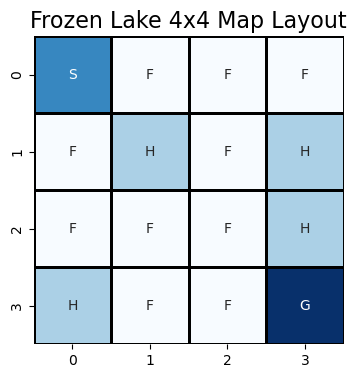

Starting training for 20000 episodes...
Episode 2000/20000: avg_reward(last 1000)=-0.002, epsilon=0.7408
Episode 4000/20000: avg_reward(last 1000)=0.023, epsilon=0.5488
Episode 6000/20000: avg_reward(last 1000)=0.063, epsilon=0.4065
Episode 8000/20000: avg_reward(last 1000)=0.096, epsilon=0.3012
Episode 10000/20000: avg_reward(last 1000)=0.134, epsilon=0.2231
Episode 12000/20000: avg_reward(last 1000)=0.238, epsilon=0.1653
Episode 14000/20000: avg_reward(last 1000)=0.272, epsilon=0.1224
Episode 16000/20000: avg_reward(last 1000)=0.330, epsilon=0.0907
Episode 18000/20000: avg_reward(last 1000)=0.407, epsilon=0.0672
Episode 20000/20000: avg_reward(last 1000)=0.464, epsilon=0.0500
Training completed!


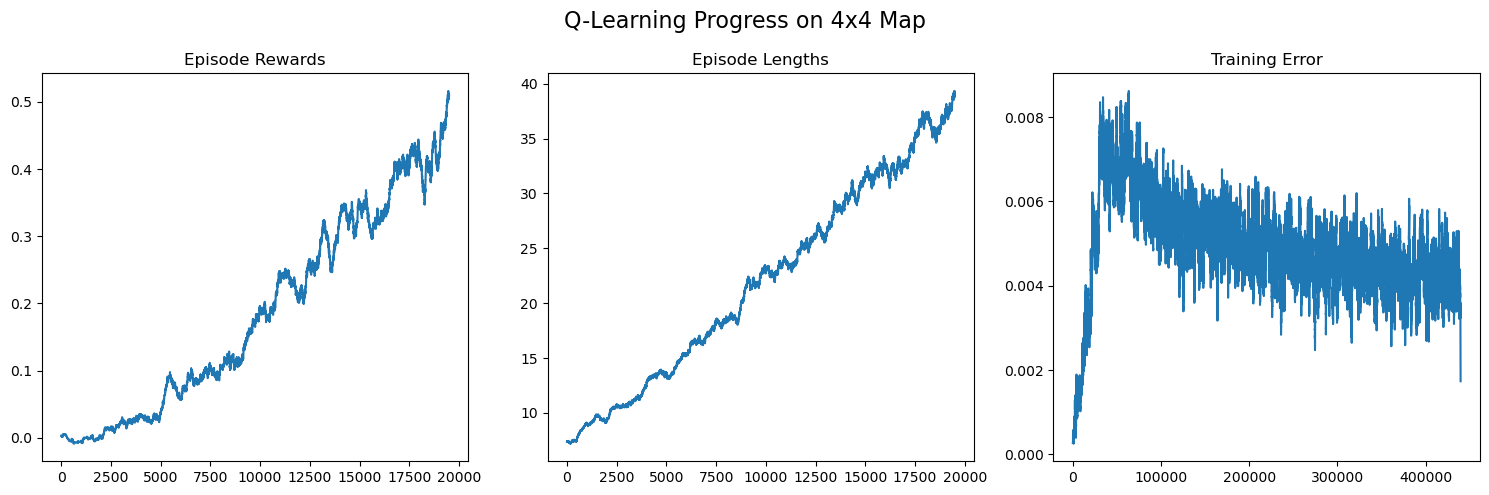


 FINAL EVALUATION & BASELINE COMPARISON
Q-learning Agent Success Rate: 0.741 (74.1%)

 BASELINE COMPARISONS
Random Policy Success Rate: 0.015 (1.5%)
Heuristic Policy Success Rate: 0.037 (3.7%)

 PERFORMANCE SUMMARY
Q-learning Agent: 0.741 (74.1%)
Random Baseline: 0.015 (1.5%)
Heuristic Baseline: 0.037 (3.7%)
Improvement over Random: 49.4x better
Improvement over Heuristic: 20.0x better

--- Running 8x8 Experiment ---

STARTING EXPERIMENT FOR MAP: 8x8

Visualizing the 8x8 grid:


C:\Users\Lara\AppData\Local\Temp\ipykernel_8964\1188224990.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Blues", 4)


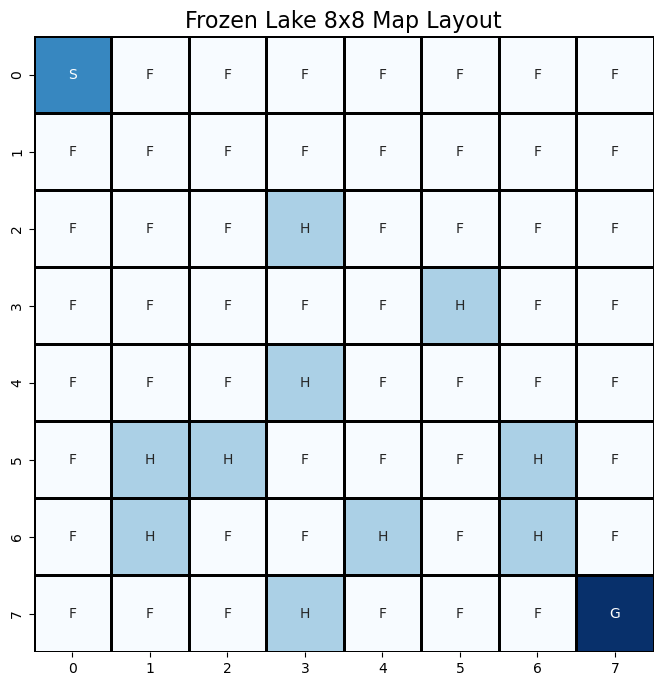

Starting training for 100000 episodes...
Episode 10000/100000: avg_reward(last 1000)=-0.048, epsilon=0.7945
Episode 20000/100000: avg_reward(last 1000)=-0.077, epsilon=0.6313
Episode 30000/100000: avg_reward(last 1000)=-0.049, epsilon=0.5016
Episode 40000/100000: avg_reward(last 1000)=-0.024, epsilon=0.3985
Episode 50000/100000: avg_reward(last 1000)=0.017, epsilon=0.3166
Episode 60000/100000: avg_reward(last 1000)=0.068, epsilon=0.2516
Episode 70000/100000: avg_reward(last 1000)=0.118, epsilon=0.1999
Episode 80000/100000: avg_reward(last 1000)=0.172, epsilon=0.1588
Episode 90000/100000: avg_reward(last 1000)=0.217, epsilon=0.1262
Episode 100000/100000: avg_reward(last 1000)=0.209, epsilon=0.1003
Training completed!


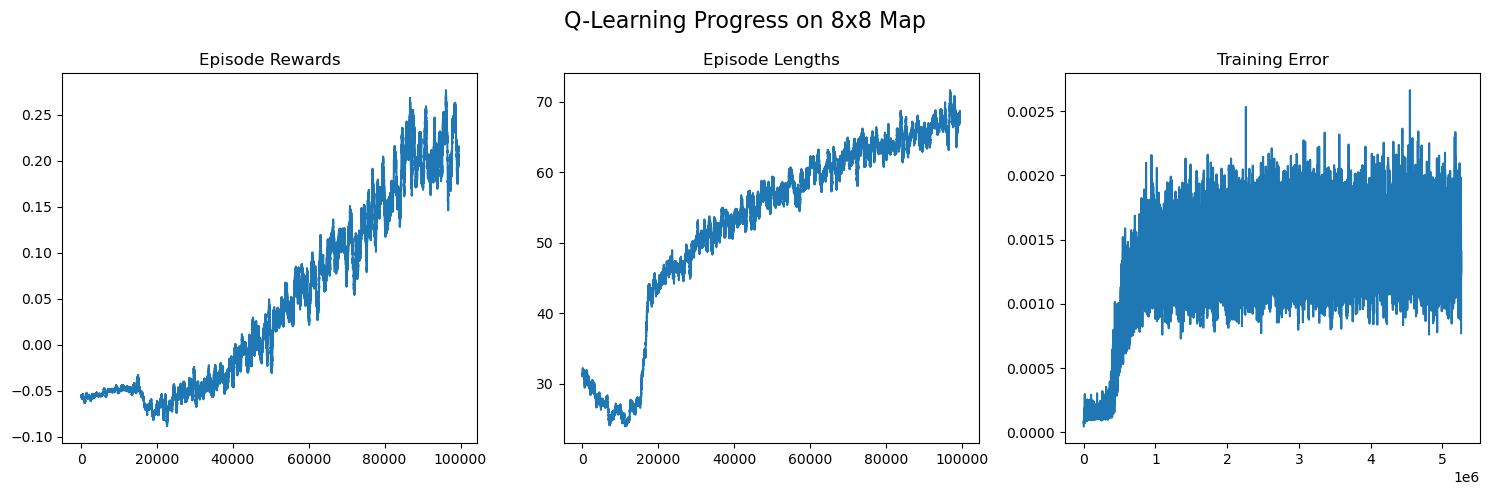


 FINAL EVALUATION & BASELINE COMPARISON
Q-learning Agent Success Rate: 0.601 (60.1%)

 BASELINE COMPARISONS
Random Policy Success Rate: 0.002 (0.2%)
Heuristic Policy Success Rate: 0.015 (1.5%)

 PERFORMANCE SUMMARY
Q-learning Agent: 0.601 (60.1%)
Random Baseline: 0.002 (0.2%)
Heuristic Baseline: 0.015 (1.5%)
Improvement over Random: 300.5x better
Improvement over Heuristic: 40.1x better


--- FINAL EXPERIMENT RESULTS ---
4x4 Map Final Success Rate: 0.741
8x8 Map Final Success Rate: 0.601


In [5]:
# Cell 5: Running experiments and visualizing the grid

def visualize_grid(env, map_name):
    """Displays the FrozenLake grid using a heatmap for easy interpretation."""
    desc = env.unwrapped.desc.astype(str)
    size = len(desc)

    color_map = {"F": 0, "H": 1, "S": 2, "G": 3}
    grid_data = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            grid_data[i, j] = color_map.get(desc[i, j], 0)

    fig, ax = plt.subplots(figsize=(size, size))

    cmap = plt.cm.get_cmap("Blues", 4)

    sns.heatmap(
        grid_data,
        annot=desc,
        fmt="",
        cmap=cmap,
        cbar=False,
        linewidths=1,
        linecolor="black",
        ax=ax
    )

    ax.set_title(f"Frozen Lake {map_name} Map Layout", fontsize=16)
    ax.set_xticks(np.arange(size) + 0.5)
    ax.set_yticks(np.arange(size) + 0.5)
    ax.set_xticklabels(np.arange(size))
    ax.set_yticklabels(np.arange(size))
    plt.show()


# Run 4x4 Experiment
print("\n--- Running 4x4 Experiment ---")
agent_params_4x4 = get_agent_params(P_4X4)
final_rate_4x4 = run_experiment("4x4", COMMON_ENV_CONFIG, P_4X4, agent_params_4x4)

# Run 8x8 Experiment
print("\n--- Running 8x8 Experiment ---")
agent_params_8x8 = get_agent_params(P_8X8)
final_rate_8x8 = run_experiment("8x8", COMMON_ENV_CONFIG, P_8X8, agent_params_8x8)

print("\n\n--- FINAL EXPERIMENT RESULTS ---")
print(f"4x4 Map Final Success Rate: {final_rate_4x4:.3f}")
print(f"8x8 Map Final Success Rate: {final_rate_8x8:.3f}")
